In [10]:
import os
import numpy as np
import imageio
from IPython.display import clear_output
import optuna
from tqdm.auto import tqdm
from sparsemax import Sparsemax

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import sklearn
from sklearn.neighbors import NearestNeighbors

from matplotlib import pyplot as plt
from attractors import Attractor
from sklearn.cluster import KMeans

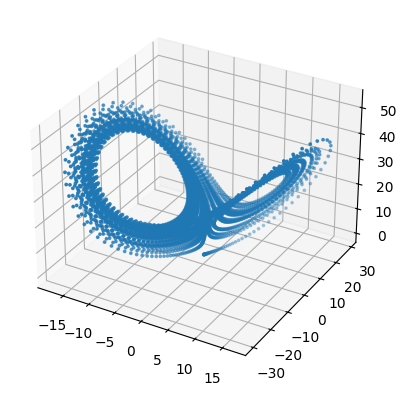

In [11]:
attr = Attractor("lorenz").rk4(0, 50, 5000)
df_lorenz = np.array([[i.X, i.Y, i.Z] for i in attr])
ax = plt.axes(projection="3d")
# ax.view_init(elev=20, azim=-70)
ax.scatter3D(df_lorenz.T[0], df_lorenz.T[1], df_lorenz.T[2], s=3)
plt.show()

In [12]:
class Dataset(Dataset):
   def __init__(self, data, targets=None):
       self.data = torch.from_numpy(data).float()

       self.targets = torch.from_numpy(targets).float() if targets is not None else None

   def __len__(self):
       return len(self.data)

   def __getitem__(self, idx):
       if self.targets is not None:
           return self.data[idx], self.targets[idx]
       else:
           return self.data[idx]

In [13]:
batch_size=256
lorenz_dataset = Dataset(df_lorenz)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [15]:
l_sz = 8

def get_encoder(d_input=3, d_latent=1, layer_sz=l_sz, alpha=1.0):
    encoder = nn.Sequential(
        nn.Linear(d_input, layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, d_latent)
    )
    return encoder

def get_decoder(d_latent=1, d_output=3, layer_sz=l_sz, alpha=1.0):
    decoder = nn.Sequential(
        nn.Linear(d_latent, layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, d_output)
    )
    return decoder

In [16]:
class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        loss = ((recon - x) ** 2).view(len(x), -1).mean(dim=1).mean()
        mse_loss = F.mse_loss(recon, x)
        return {"recon": recon, "loss": loss, 'mse_loss': mse_loss}

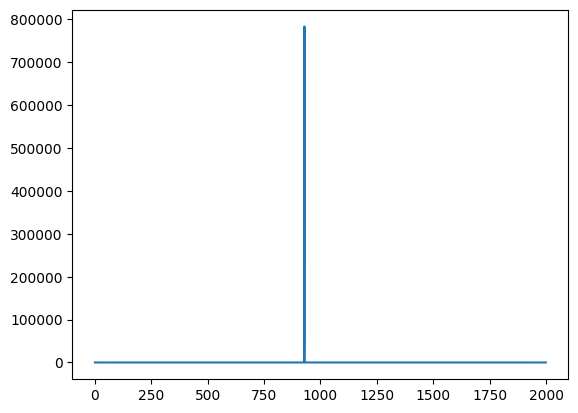

[I 2025-03-29 17:08:36,481] Trial 4 finished with value: 430.5056002386608 and parameters: {'hidden_dim': 256, 'learning_rate': 0.00368994356276861}. Best is trial 3 with value: 5.568863688345625.



Trial 5
Current parameters: {'hidden_dim': 8, 'learning_rate': 0.08524653109804542}


  3%|▎         | 66/2000 [00:01<00:47, 40.64it/s]
[I 2025-03-29 17:08:38,108] Trial 5 pruned. 



Trial 6
Current parameters: {'hidden_dim': 64, 'learning_rate': 0.00015091766317526585}


  0%|          | 0/2000 [00:00<?, ?it/s]
[I 2025-03-29 17:08:38,143] Trial 6 pruned. 



Trial 7
Current parameters: {'hidden_dim': 128, 'learning_rate': 0.08684890420270414}


  0%|          | 0/2000 [00:00<?, ?it/s]
[I 2025-03-29 17:08:38,192] Trial 7 pruned. 



Trial 8
Current parameters: {'hidden_dim': 256, 'learning_rate': 0.000270650104577631}


  0%|          | 1/2000 [00:00<04:27,  7.47it/s]
[I 2025-03-29 17:08:38,328] Trial 8 pruned. 



Trial 9
Current parameters: {'hidden_dim': 128, 'learning_rate': 0.0004941631865365329}


  0%|          | 5/2000 [00:00<01:45, 18.96it/s]
[I 2025-03-29 17:08:38,596] Trial 9 pruned. 


Best trial:
  Value:  5.568863688345625
  Params: 
    hidden_dim: 32
    learning_rate: 0.002471197709344674


In [17]:
def objective(trial):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [8, 16, 32, 64, 128, 256]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
    }

    print(f"\nTrial {trial.number}")
    print(f"Current parameters:", trial.params)


    train_loader = DataLoader(
        lorenz_dataset,
        batch_size=128,
        shuffle=True
    )

    model = AE(
        encoder=get_encoder(3, 1, params['hidden_dim']),
        decoder=get_decoder(1, 3, params['hidden_dim']),
    ).to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=params['learning_rate'],
        weight_decay=1e-5
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=500,
        eta_min=1e-6
    )


    criterion = nn.MSELoss()
    
    n_epochs = 2000
    losses = []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        epoch_losses = []
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            recon = output['recon']
            loss = output['loss']
            mse_loss = output['mse_loss']
            loss.backward()
            optimizer.step()
            epoch_losses.append(mse_loss.item())

        scheduler.step(epoch)

        trial.report(np.mean(epoch_losses), epoch)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        losses.append(np.mean(epoch_losses))

    output = model(lorenz_dataset.data.to(device))
    recon = np.array(output['recon'].data.cpu())
    
    clear_output()
    
    plt.plot(losses)
    plt.show()

    return np.mean(losses)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_trial.params
best_model = AE(
    encoder=get_encoder(3, 1, best_params['hidden_dim']),
    decoder=get_decoder(1, 3, best_params['hidden_dim']),
).to(device)
best_optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=best_params['learning_rate'],
)

Loss: 7.413865209255368


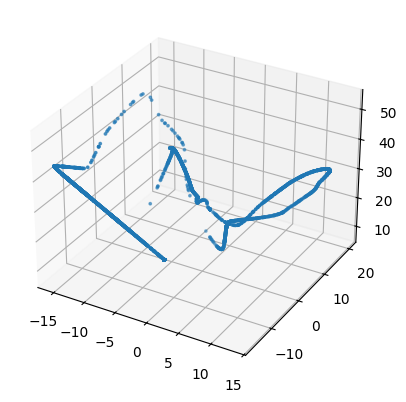

In [24]:
train_loader = DataLoader(
    lorenz_dataset,
    batch_size=128,
    shuffle=True
)
best_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    best_optimizer,
    T_max=500,
    eta_min=1e-6
)

criterion = nn.MSELoss()

n_epochs = 2000
losses = []
for epoch in tqdm(range(n_epochs)):
    best_model.train()
    epoch_losses = []
    for batch in train_loader:
        batch = batch.to(device)
        best_optimizer.zero_grad()
        output = best_model(batch)
        recon = output['recon']
        loss = output['loss']
        mse_loss = output['mse_loss']
        loss.backward()
        best_optimizer.step()
        epoch_losses.append(mse_loss.item())

    best_scheduler.step()
    losses.append(np.mean(epoch_losses))

output = best_model(lorenz_dataset.data.to(device))
recon = np.array(output['recon'].data.cpu())

clear_output()

ax = plt.axes(projection="3d")
ax.scatter3D(recon[:, 0], recon[:, 1], recon[:, 2], s=3)

print(f'Loss: {np.mean(losses)}')
plt.show()

In [25]:
class ChartingAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim, n_charts, alpha=1.0, gamma=1.0, beta=1.0):
        super().__init__()
        self.n_charts = n_charts
        self.gamma = gamma
        self.beta = beta
        self.encoders = nn.ModuleList([get_encoder(input_dim, latent_dim, hidden_dim, alpha) for _ in range(n_charts)])
        self.decoders = nn.ModuleList([get_decoder(latent_dim, input_dim, hidden_dim, alpha) for _ in range(n_charts)])
        self.proba = nn.Sequential(nn.Linear(input_dim, n_charts), Sparsemax(1))

    def recon_loss(self, x, z):
        x_recons = torch.stack([h_i(z[:, i]) for i, h_i in enumerate(self.decoders)], dim=1)
        
        recon_errors = torch.norm(x.unsqueeze(1) - x_recons, dim=-1)**2
        p = self.proba(x)
        loss = torch.mean(p * recon_errors)
        return loss, recon_errors

    def transition_loss(self, recon_errors, p):
        q = torch.softmax(-recon_errors, dim=-1)
        loss = -torch.sum(q * torch.log(p + 1e-8), dim=-1).mean()
        return loss

    def nondominance_loss(self, p):
        mean_p = p.mean(dim=0)
        target = torch.ones_like(mean_p) / self.n_charts
        loss = torch.sum((mean_p - target)**2)
        return loss
    
    def forward(self, x):
        z = torch.stack([g_i(x) for g_i in self.encoders], dim=1)
        p = self.proba(x)
        x_recons = torch.stack([h_i(z[:, i]) for i, h_i in enumerate(self.decoders)], dim=1)
        recon_x = torch.sum(x_recons * p.unsqueeze(-1), dim=1)
        
        recon_loss, recon_errors = self.recon_loss(x, z)
        trans_loss = self.transition_loss(recon_errors, p)
        nondom_loss = self.nondominance_loss(p)
        
        total_loss = recon_loss + self.gamma * trans_loss + self.beta * nondom_loss

        mse_loss = F.mse_loss(recon_x, x)
        
        return {
            'recon': recon_x,
            'latent': z,
            'probabilities': p,
            'total_loss': total_loss,
            'recon_loss': recon_loss,
            'nondom_loss': nondom_loss,
            'transition_loss': trans_loss,
            'mse_loss': mse_loss
        }

Epoch 1500/1500:
Total Loss: 2.4005
Recon Loss: 2.3718
Trans Loss: 0.0621
Nondom Loss: 0.0059
MSE Loss: 1.5347


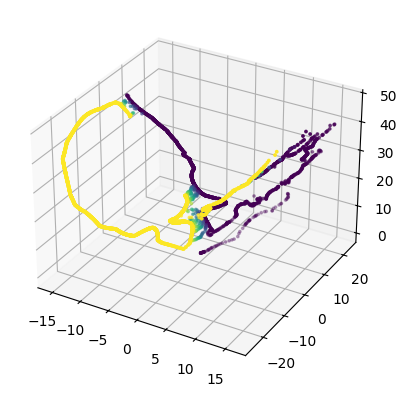

[I 2025-03-29 19:30:08,088] Trial 35 finished with value: 30.647953629493713 and parameters: {'hidden_dim': 64, 'learning_rate': 0.0002684738013066739, 'n_charts': 2, 'alpha': 22.10288224141478, 'gamma': 0.12801305286141101, 'beta': 3.5387059131416003}. Best is trial 35 with value: 30.647953629493713.



Trial 36
Current parameters: {'hidden_dim': 8, 'learning_rate': 0.00039565523382029984, 'n_charts': 2, 'alpha': 60.37945208937878, 'gamma': 0.02993228711250988, 'beta': 16.962974120880737}


  0%|          | 0/1500 [00:00<?, ?it/s]
[I 2025-03-29 19:30:08,134] Trial 36 pruned. 



Trial 37
Current parameters: {'hidden_dim': 16, 'learning_rate': 0.0003175929180119777, 'n_charts': 1, 'alpha': 22.048404492640557, 'gamma': 0.6089228107910742, 'beta': 465.9605836600661}


  0%|          | 0/1500 [00:00<?, ?it/s]
[I 2025-03-29 19:30:08,169] Trial 37 pruned. 



Trial 38
Current parameters: {'hidden_dim': 64, 'learning_rate': 0.0006598582357454766, 'n_charts': 2, 'alpha': 13.185861470899399, 'gamma': 0.07203042389311742, 'beta': 3.6824290567816753}


  0%|          | 1/1500 [00:00<02:38,  9.48it/s]
[I 2025-03-29 19:30:08,285] Trial 38 pruned. 



Trial 39
Current parameters: {'hidden_dim': 256, 'learning_rate': 0.0014916255606568043, 'n_charts': 2, 'alpha': 42.853724502730444, 'gamma': 0.29157429808790203, 'beta': 7.039651080537418}


  0%|          | 0/1500 [00:00<?, ?it/s]
[I 2025-03-29 19:30:08,400] Trial 39 pruned. 



Trial 40
Current parameters: {'hidden_dim': 32, 'learning_rate': 0.00839339089328247, 'n_charts': 1, 'alpha': 5.01203654232635, 'gamma': 0.6385727901951288, 'beta': 10.178574081346436}


  7%|▋         | 100/1500 [00:02<00:35, 38.91it/s]
[I 2025-03-29 19:30:10,980] Trial 40 pruned. 



Trial 41
Current parameters: {'hidden_dim': 64, 'learning_rate': 0.00017656533738328608, 'n_charts': 2, 'alpha': 25.532198281731073, 'gamma': 0.1546972106627363, 'beta': 2.006930454744649}


  0%|          | 0/1500 [00:00<?, ?it/s]
[I 2025-03-29 19:30:11,038] Trial 41 pruned. 



Trial 42
Current parameters: {'hidden_dim': 64, 'learning_rate': 0.00023740287040309408, 'n_charts': 2, 'alpha': 17.577798817222252, 'gamma': 0.09413595512499513, 'beta': 2.2816134965240806}


  0%|          | 0/1500 [00:00<?, ?it/s]
[I 2025-03-29 19:30:11,096] Trial 42 pruned. 



Trial 43
Current parameters: {'hidden_dim': 64, 'learning_rate': 0.00011950092962657073, 'n_charts': 2, 'alpha': 12.451990088049547, 'gamma': 0.04388317471630194, 'beta': 1.3313228095822658}


  0%|          | 1/1500 [00:00<02:23, 10.47it/s]
[I 2025-03-29 19:30:11,201] Trial 43 pruned. 



Trial 44
Current parameters: {'hidden_dim': 128, 'learning_rate': 0.00046779599090440764, 'n_charts': 2, 'alpha': 30.30778774253685, 'gamma': 0.12960399969844644, 'beta': 1.0323317420949638}


  1%|          | 14/1500 [00:01<01:47, 13.80it/s]
[I 2025-03-29 19:30:12,226] Trial 44 pruned. 



Trial 45
Current parameters: {'hidden_dim': 64, 'learning_rate': 0.0002741360322562452, 'n_charts': 2, 'alpha': 82.309273745295, 'gamma': 0.01780096315884287, 'beta': 2.9945078669740806}


  0%|          | 0/1500 [00:00<?, ?it/s]
[I 2025-03-29 19:30:12,285] Trial 45 pruned. 



Trial 46
Current parameters: {'hidden_dim': 256, 'learning_rate': 0.0002069187379615205, 'n_charts': 2, 'alpha': 24.889869075977852, 'gamma': 1.9792665956600208, 'beta': 4.49745296209457}


  1%|          | 18/1500 [00:01<02:42,  9.14it/s]
[I 2025-03-29 19:30:14,265] Trial 46 pruned. 



Trial 47
Current parameters: {'hidden_dim': 64, 'learning_rate': 0.00011939362438446476, 'n_charts': 2, 'alpha': 47.667813925042054, 'gamma': 0.20072700790201606, 'beta': 17.25689685863993}


  0%|          | 0/1500 [00:00<?, ?it/s]
[I 2025-03-29 19:30:14,334] Trial 47 pruned. 



Trial 48
Current parameters: {'hidden_dim': 64, 'learning_rate': 0.00015626629078123596, 'n_charts': 2, 'alpha': 5.332938191156872, 'gamma': 0.0872305648573105, 'beta': 2.134663595897236}


  0%|          | 0/1500 [00:00<?, ?it/s]
[I 2025-03-29 19:30:14,404] Trial 48 pruned. 



Trial 49
Current parameters: {'hidden_dim': 32, 'learning_rate': 0.00017826302944879964, 'n_charts': 2, 'alpha': 38.96485271033198, 'gamma': 0.40388896299647253, 'beta': 145.47301448918773}


  0%|          | 0/1500 [00:00<?, ?it/s]
[I 2025-03-29 19:30:14,457] Trial 49 pruned. 


Best trial:
  Value:  30.647953629493713
  Params: 
    hidden_dim: 64
    learning_rate: 0.0002684738013066739
    n_charts: 2
    alpha: 22.10288224141478
    gamma: 0.12801305286141101
    beta: 3.5387059131416003


In [33]:
def objective(trial):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [8, 16, 32, 64, 128, 256]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'n_charts': trial.suggest_int('n_charts', 1, 2),
        'alpha': trial.suggest_float('alpha', 0.01, 100.0),
        'gamma': trial.suggest_float('gamma', 0.01, 100.0, log=True),
        'beta': trial.suggest_float('beta', 1, 1000, log=True),
    }

    print(f"\nTrial {trial.number}")
    print(f"Current parameters:", trial.params)


    train_loader = DataLoader(
        lorenz_dataset,
        batch_size=256,
        shuffle=True
    )

    model = ChartingAE(
        input_dim=3,
        latent_dim=1,
        n_charts=params['n_charts'],
        hidden_dim=params['hidden_dim'],
        alpha=params['alpha'],
        gamma=params['gamma'],
        beta=params['beta']
    ).to(device)

    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=params['learning_rate'],
        weight_decay=1e-5
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=500,
        eta_min=1e-6
    )

    n_epochs = 1500
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            output['total_loss'].backward()
            optimizer.step()
            total_loss += output['mse_loss'].item()

        scheduler.step()

        trial.report(total_loss, epoch)
        
        if trial.should_prune():
            raise optuna.TrialPruned()

    output = model(lorenz_dataset.data.to(device))
    recon = output['recon'].detach().cpu().numpy()
    probs = output['probabilities'].detach().cpu().numpy()

    clear_output()
    
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'Total Loss: {output["total_loss"].mean():.4f}')
    print(f'Recon Loss: {output["recon_loss"].mean():.4f}')
    print(f'Trans Loss: {output["transition_loss"].mean():.4f}')
    print(f'Nondom Loss: {output["nondom_loss"].mean():.4f}')
    print(f'MSE Loss: {output["mse_loss"].mean():.4f}')

    ax = plt.axes(projection="3d")
    ax.scatter3D(recon[:, 0], recon[:, 1], recon[:, 2], s=3, c=probs[:, 0])
    
    plt.show()

    return total_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_trial.params
best_model = ChartingAE(
    input_dim=3,
    latent_dim=1,
    n_charts=best_params['n_charts'],
    hidden_dim=best_params['hidden_dim'],
    alpha=best_params['alpha'],
    gamma=best_params['gamma'],
    beta=best_params['beta']
).to(device)

best_optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=1e-5
)

Epoch 5000/5000:
Total Loss: 3.8390
Recon Loss: 3.8158
Trans Loss: 0.0671
Nondom Loss: 0.0041
MSE Loss: 2.4110


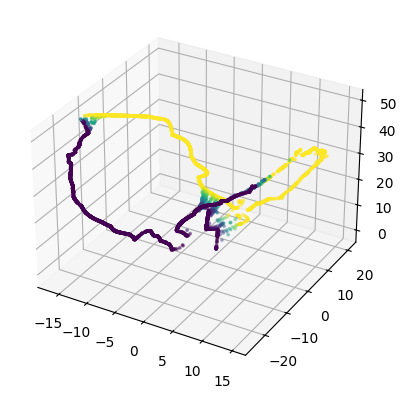

In [34]:
best_train_loader = DataLoader(
    lorenz_dataset,
    batch_size=256,
    shuffle=True
)

best_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    best_optimizer,
    T_max=500,
    eta_min=1e-6
)

n_epochs = 5000
for epoch in tqdm(range(n_epochs)):
    best_model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        best_optimizer.zero_grad()
        output = best_model(batch)
        output['total_loss'].backward()
        best_optimizer.step()
        total_loss += output['total_loss'].item()

    best_scheduler.step()


output = best_model(lorenz_dataset.data.to(device))
recon = output['recon'].detach().cpu().numpy()
probs = output['probabilities'].detach().cpu().numpy()

clear_output()

print(f'Epoch {epoch+1}/{n_epochs}:')
print(f'Total Loss: {output["total_loss"].mean():.4f}')
print(f'Recon Loss: {output["recon_loss"].mean():.4f}')
print(f'Trans Loss: {output["transition_loss"].mean():.4f}')
print(f'Nondom Loss: {output["nondom_loss"].mean():.4f}')
print(f'MSE Loss: {output["mse_loss"].mean():.4f}')

ax = plt.axes(projection="3d")
ax.scatter3D(recon[:, 0], recon[:, 1], recon[:, 2], s=3, c=probs[:, 0])

plt.show()